# Recognize Indian Currency by using Transfer Learning

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/fastai-v3'

Mounted at /content/drive


In [0]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
os.listdir(base_dir)

['Glasses-NoGlasses',
 'kaggle.json',
 'Currency-Dataset',
 'Indian-Currency-Dataset']

## Setup Input Pipeline

In [0]:
# path_data = base_dir + '/Indian-Currency-Dataset/train'
# path_test = base_dir + '/Indian-Currency-Dataset/test'
path_train_cropped = base_dir + '/Indian-Currency-Dataset/train-cropped'
path_valid_cropped = base_dir + '/Indian-Currency-Dataset/valid-cropped'
path_test_cropped = base_dir + '/Indian-Currency-Dataset/test-cropped'
path_aug = base_dir + '/Indian-Currency-Dataset/augmented_images'

os.listdir(base_dir + '/Indian-Currency-Dataset/')

['test', 'train', 'train-cropped', 'test-cropped', 'valid-cropped', 'models']

In [0]:
# IMAGE_SIZE = 448
# BATCH_SIZE = 16

# train_datagen = ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     rotation_range = 180
#     # brightness_range=[1.2, 0.7],
#     # width_shift_range=0.3,
#     # height_shift_range=0.3,
#     # fill_mode = 'constant',
#     )

# test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# train_generator = train_datagen.flow_from_directory(
#     path_train_cropped,
#     classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
#     target_size = (IMAGE_SIZE, IMAGE_SIZE),
#     seed = 10,
#     # save_to_dir = path_aug,
#     # save_prefix = 'tr-0',
#     # save_format = 'jpg',
#     batch_size = BATCH_SIZE)

# val_generator = test_datagen.flow_from_directory(
#     path_valid_cropped,
#     classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
#     target_size = (IMAGE_SIZE, IMAGE_SIZE),
#     batch_size = BATCH_SIZE,
#     seed = 3)

# test_generator = test_datagen.flow_from_directory(path_test_cropped,
#                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
#                                                   batch_size=BATCH_SIZE)

Found 4407 images belonging to 9 classes.
Found 871 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
IMAGE_SIZE = 448
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 180
    # brightness_range=[1.2, 0.7],
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # fill_mode = 'constant',
    )

test_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow_from_directory(
    path_train_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    seed = 10,
    # save_to_dir = path_aug,
    # save_prefix = 'tr-0',
    # save_format = 'jpg',
    batch_size = BATCH_SIZE)

val_generator = test_datagen.flow_from_directory(
    path_valid_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    seed = 3)

test_generator = test_datagen.flow_from_directory(path_test_cropped,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 4407 images belonging to 9 classes.
Found 871 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights= 'imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
base_model.trainable = False

In [0]:
# model.load_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-ResNet-top.h5')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 14, 14, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
activation_1 (Activation)    (None, 512)              

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 429s 2s/step - loss: 1.2919 - categorical_accuracy: 0.6138 - val_loss: 1.0193 - val_categorical_accuracy: 0.7325
Epoch 2/5
276/276 [==============================] - 423s 2s/step - loss: 0.7683 - categorical_accuracy: 0.7581 - val_loss: 0.8776 - val_categorical_accuracy: 0.7290
Epoch 3/5
276/276 [==============================] - 422s 2s/step - loss: 0.6571 - categorical_accuracy: 0.7862 - val_loss: 0.8249 - val_categorical_accuracy: 0.7566
Epoch 4/5
276/276 [==============================] - 423s 2s/step - loss: 0.6053 - categorical_accuracy: 0.8071 - val_loss: 0.9020 - val_categorical_accuracy: 0.7268
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.5784 - categorical_accuracy: 0.8169 - val_loss: 0.8195 - val_categorical_accuracy: 0.7336


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-top.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,                    
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 444s 2s/step - loss: 0.0373 - categorical_accuracy: 0.9887 - val_loss: 0.1079 - val_categorical_accuracy: 0.9598
Epoch 2/5
276/276 [==============================] - 444s 2s/step - loss: 0.0392 - categorical_accuracy: 0.9875 - val_loss: 0.1688 - val_categorical_accuracy: 0.9552
Epoch 3/5
276/276 [==============================] - 445s 2s/step - loss: 0.0550 - categorical_accuracy: 0.9821 - val_loss: 0.1483 - val_categorical_accuracy: 0.9483
Epoch 4/5
276/276 [==============================] - 444s 2s/step - loss: 0.0358 - categorical_accuracy: 0.9868 - val_loss: 0.1878 - val_categorical_accuracy: 0.9380
Epoch 5/5
276/276 [==============================] - 444s 2s/step - loss: 0.0324 - categorical_accuracy: 0.9905 - val_loss: 0.1771 - val_categorical_accuracy: 0.9483


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-MobNet-top.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 426s 2s/step - loss: 1.3194 - categorical_accuracy: 0.6152 - val_loss: 1.0072 - val_categorical_accuracy: 0.7084
Epoch 2/5
276/276 [==============================] - 424s 2s/step - loss: 0.7737 - categorical_accuracy: 0.7522 - val_loss: 1.2903 - val_categorical_accuracy: 0.6326
Epoch 3/5
276/276 [==============================] - 424s 2s/step - loss: 0.6387 - categorical_accuracy: 0.7942 - val_loss: 0.8219 - val_categorical_accuracy: 0.7635
Epoch 4/5
276/276 [==============================] - 425s 2s/step - loss: 0.5548 - categorical_accuracy: 0.8219 - val_loss: 0.6462 - val_categorical_accuracy: 0.8048
Epoch 5/5
276/276 [==============================] - 426s 2s/step - loss: 0.5581 - categorical_accuracy: 0.8101 - val_loss: 0.7489 - val_categorical_accuracy: 0.7807


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-ResNet-top.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 425s 2s/step - loss: 0.5540 - categorical_accuracy: 0.8207 - val_loss: 0.7490 - val_categorical_accuracy: 0.7796
Epoch 2/5
276/276 [==============================] - 423s 2s/step - loss: 0.4980 - categorical_accuracy: 0.8312 - val_loss: 0.8104 - val_categorical_accuracy: 0.7543
Epoch 3/5
276/276 [==============================] - 423s 2s/step - loss: 0.5042 - categorical_accuracy: 0.8353 - val_loss: 0.8499 - val_categorical_accuracy: 0.7635
Epoch 4/5
276/276 [==============================] - 424s 2s/step - loss: 0.4574 - categorical_accuracy: 0.8462 - val_loss: 0.8799 - val_categorical_accuracy: 0.7382
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.4525 - categorical_accuracy: 0.8491 - val_loss: 0.7113 - val_categorical_accuracy: 0.7842


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-ResNet-top.h5')

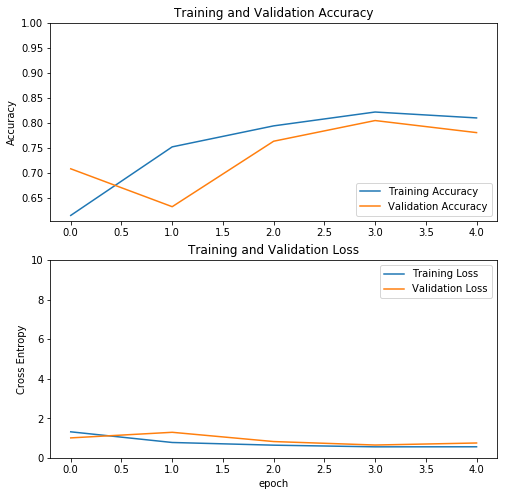

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
epochs = 40

history_1 = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.5543 - accuracy: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 58s 2s/step - loss: 0.5545 - accuracy: 0.8519 - val_loss: 4.2724 - val_accuracy: 0.3008
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.5564 - accuracy: 0.8428 - val_loss: 4.7080 - val_accuracy: 0.3171
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 0.4311 - accuracy: 0.8655 - val_loss: 5.3580 - val_accuracy: 0.2947
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.4088 - accuracy: 0.8705 - val_loss: 4.1000 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.3656 - accuracy: 0.8927 - val_loss: 5.6942 - val_accuracy: 0.3130
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.4129 - accuracy: 0.8670 - val_loss: 5.0287 - val_accuracy: 0.3130
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.3456 - accuracy: 0.8877 - val_loss: 4.8635 - val_accuracy: 0.3354
Epoch 8/40
32/32 [=============

In [0]:
model.save(path_data + '/save/fine_tuning/stage-2.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2.h5')

### Un-freeze the top layers of the model


In [0]:
# model.layers[0].trainable = True
# base_model.trainable = False
# model.load_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 158

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [0]:
model.load_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from158-ResNet.h5')

### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 14, 14, 2048)      23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation (Activation)      (None, 512)               0

### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 427s 2s/step - loss: 0.4366 - categorical_accuracy: 0.8507 - val_loss: 0.6733 - val_categorical_accuracy: 0.7842
Epoch 2/5
276/276 [==============================] - 426s 2s/step - loss: 0.4001 - categorical_accuracy: 0.8607 - val_loss: 0.6386 - val_categorical_accuracy: 0.7933
Epoch 3/5
276/276 [==============================] - 426s 2s/step - loss: 0.4321 - categorical_accuracy: 0.8543 - val_loss: 0.6493 - val_categorical_accuracy: 0.7979
Epoch 4/5
276/276 [==============================] - 425s 2s/step - loss: 0.3973 - categorical_accuracy: 0.8625 - val_loss: 0.6450 - val_categorical_accuracy: 0.7979
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.4339 - categorical_accuracy: 0.8541 - val_loss: 0.6168 - val_categorical_accuracy: 0.8083


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-from170-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 425s 2s/step - loss: 0.3769 - categorical_accuracy: 0.8716 - val_loss: 0.5591 - val_categorical_accuracy: 0.8266
Epoch 2/5
276/276 [==============================] - 423s 2s/step - loss: 0.3378 - categorical_accuracy: 0.8861 - val_loss: 0.5509 - val_categorical_accuracy: 0.8255
Epoch 3/5
276/276 [==============================] - 424s 2s/step - loss: 0.3299 - categorical_accuracy: 0.8879 - val_loss: 0.5457 - val_categorical_accuracy: 0.8324
Epoch 4/5
276/276 [==============================] - 424s 2s/step - loss: 0.3240 - categorical_accuracy: 0.8899 - val_loss: 0.5231 - val_categorical_accuracy: 0.8427
Epoch 5/5
276/276 [==============================] - 424s 2s/step - loss: 0.2884 - categorical_accuracy: 0.9027 - val_loss: 0.5170 - val_categorical_accuracy: 0.8358


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-from170-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 2294s 8s/step - loss: 0.2813 - categorical_accuracy: 0.9092 - val_loss: 0.5806 - val_categorical_accuracy: 0.8209
Epoch 2/5
276/276 [==============================] - 418s 2s/step - loss: 0.2590 - categorical_accuracy: 0.9086 - val_loss: 0.5844 - val_categorical_accuracy: 0.8266
Epoch 3/5
276/276 [==============================] - 418s 2s/step - loss: 0.2409 - categorical_accuracy: 0.9163 - val_loss: 0.5319 - val_categorical_accuracy: 0.8381
Epoch 4/5
276/276 [==============================] - 418s 2s/step - loss: 0.2148 - categorical_accuracy: 0.9301 - val_loss: 0.4913 - val_categorical_accuracy: 0.8462
Epoch 5/5
276/276 [==============================] - 418s 2s/step - loss: 0.2129 - categorical_accuracy: 0.9260 - val_loss: 0.4599 - val_categorical_accuracy: 0.8553


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-3-from170-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 420s 2s/step - loss: 0.2236 - categorical_accuracy: 0.9204 - val_loss: 0.4767 - val_categorical_accuracy: 0.8542
Epoch 2/5
276/276 [==============================] - 418s 2s/step - loss: 0.2190 - categorical_accuracy: 0.9249 - val_loss: 0.5177 - val_categorical_accuracy: 0.8496
Epoch 3/5
276/276 [==============================] - 417s 2s/step - loss: 0.2065 - categorical_accuracy: 0.9335 - val_loss: 0.4855 - val_categorical_accuracy: 0.8565
Epoch 4/5
276/276 [==============================] - 418s 2s/step - loss: 0.2149 - categorical_accuracy: 0.9283 - val_loss: 0.4619 - val_categorical_accuracy: 0.8576
Epoch 5/5
276/276 [==============================] - 419s 2s/step - loss: 0.1986 - categorical_accuracy: 0.9285 - val_loss: 0.4566 - val_categorical_accuracy: 0.8611


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-4-from168-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
Epoch 1/5
275/276 [============================>.] - ETA: 7s - loss: 0.1840 - categorical_accuracy: 0.9355 Epoch 1/5
Epoch 1/5
276/276 [==============================] - 2306s 8s/step - loss: 0.1837 - categorical_accuracy: 0.9356 - val_loss: 0.3935 - val_categorical_accuracy: 0.8749
Epoch 2/5
Epoch 2/5
275/276 [============================>.] - ETA: 1s - loss: 0.1641 - categorical_accuracy: 0.9412Epoch 1/5
Epoch 1/5
276/276 [==============================] - 446s 2s/step - loss: 0.1635 - categorical_accuracy: 0.9415 - val_loss: 0.4282 - val_categorical_accuracy: 0.8760
Epoch 3/5
Epoch 3/5
275/276 [============================>.] - ETA: 1s - loss: 0.1445 - categorical_accuracy: 0.9519Epoch 1/5
Epoch 1/5
276/276 [==============================] - 446s 2s/step - loss: 0.1446 - categorical_accuracy: 0.9519 - val_loss: 0.4523 - val_categorical_accuracy: 0.8714
Epoch 4/5
Epoch 4/5
275/276 [============================>.] - ETA: 1s - loss: 0.1417 - categorical_accuracy: 0.9538Epoch 

In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-5-from168-ResNet.h5')

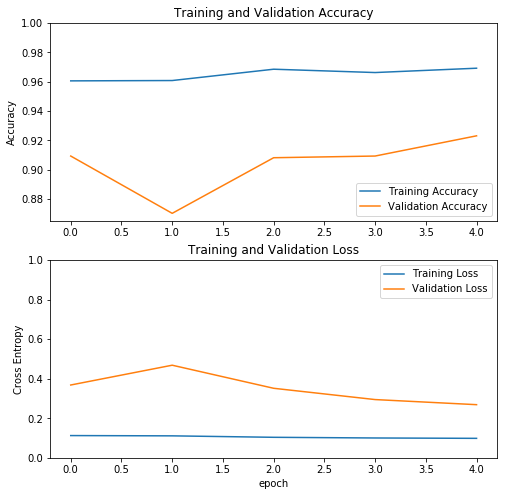

In [0]:
acc = history_fine.history['categorical_accuracy']
val_acc = history_fine.history['val_categorical_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 446s 2s/step - loss: 0.1285 - categorical_accuracy: 0.9546 - val_loss: 0.3109 - val_categorical_accuracy: 0.9070
Epoch 2/5
276/276 [==============================] - 446s 2s/step - loss: 0.1153 - categorical_accuracy: 0.9585 - val_loss: 0.3209 - val_categorical_accuracy: 0.9013
Epoch 3/5
276/276 [==============================] - 448s 2s/step - loss: 0.1166 - categorical_accuracy: 0.9598 - val_loss: 0.4919 - val_categorical_accuracy: 0.8668
Epoch 4/5
276/276 [==============================] - 449s 2s/step - loss: 0.1045 - categorical_accuracy: 0.9651 - val_loss: 0.3375 - val_categorical_accuracy: 0.9047
Epoch 5/5
276/276 [==============================] - 449s 2s/step - loss: 0.0893 - categorical_accuracy: 0.9723 - val_loss: 0.2904 - val_categorical_accuracy: 0.9070


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-6-from168-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 447s 2s/step - loss: 0.1122 - categorical_accuracy: 0.9605 - val_loss: 0.3683 - val_categorical_accuracy: 0.9093
Epoch 2/5
276/276 [==============================] - 445s 2s/step - loss: 0.1109 - categorical_accuracy: 0.9607 - val_loss: 0.4684 - val_categorical_accuracy: 0.8703
Epoch 3/5
276/276 [==============================] - 445s 2s/step - loss: 0.1036 - categorical_accuracy: 0.9685 - val_loss: 0.3517 - val_categorical_accuracy: 0.9082
Epoch 4/5
276/276 [==============================] - 448s 2s/step - loss: 0.1008 - categorical_accuracy: 0.9662 - val_loss: 0.2946 - val_categorical_accuracy: 0.9093
Epoch 5/5
276/276 [==============================] - 449s 2s/step - loss: 0.0984 - categorical_accuracy: 0.9691 - val_loss: 0.2687 - val_categorical_accuracy: 0.9231


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-7-from166-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 450s 2s/step - loss: 0.0839 - categorical_accuracy: 0.9719 - val_loss: 0.2749 - val_categorical_accuracy: 0.9208
Epoch 2/5
276/276 [==============================] - 449s 2s/step - loss: 0.0839 - categorical_accuracy: 0.9714 - val_loss: 0.2592 - val_categorical_accuracy: 0.9242
Epoch 3/5
276/276 [==============================] - 445s 2s/step - loss: 0.0809 - categorical_accuracy: 0.9716 - val_loss: 0.2475 - val_categorical_accuracy: 0.9231
Epoch 4/5
276/276 [==============================] - 446s 2s/step - loss: 0.0637 - categorical_accuracy: 0.9800 - val_loss: 0.2479 - val_categorical_accuracy: 0.9265
Epoch 5/5
276/276 [==============================] - 446s 2s/step - loss: 0.0825 - categorical_accuracy: 0.9723 - val_loss: 0.2448 - val_categorical_accuracy: 0.9288


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-8-from165-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 444s 2s/step - loss: 0.0815 - categorical_accuracy: 0.9719 - val_loss: 0.2393 - val_categorical_accuracy: 0.9300
Epoch 2/5
276/276 [==============================] - 442s 2s/step - loss: 0.0761 - categorical_accuracy: 0.9759 - val_loss: 0.1540 - val_categorical_accuracy: 0.9495
Epoch 3/5
276/276 [==============================] - 444s 2s/step - loss: 0.0652 - categorical_accuracy: 0.9784 - val_loss: 0.2637 - val_categorical_accuracy: 0.9059
Epoch 4/5
276/276 [==============================] - 445s 2s/step - loss: 0.0594 - categorical_accuracy: 0.9821 - val_loss: 0.1991 - val_categorical_accuracy: 0.9426
Epoch 5/5
276/276 [==============================] - 445s 2s/step - loss: 0.0510 - categorical_accuracy: 0.9834 - val_loss: 0.2143 - val_categorical_accuracy: 0.9311


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-9-from165-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 449s 2s/step - loss: 0.0616 - categorical_accuracy: 0.9784 - val_loss: 0.1783 - val_categorical_accuracy: 0.9426
Epoch 2/5
276/276 [==============================] - 447s 2s/step - loss: 0.0466 - categorical_accuracy: 0.9837 - val_loss: 0.1808 - val_categorical_accuracy: 0.9392
Epoch 3/5
276/276 [==============================] - 447s 2s/step - loss: 0.0494 - categorical_accuracy: 0.9825 - val_loss: 0.1734 - val_categorical_accuracy: 0.9449
Epoch 4/5
276/276 [==============================] - 448s 2s/step - loss: 0.0443 - categorical_accuracy: 0.9871 - val_loss: 0.1638 - val_categorical_accuracy: 0.9460
Epoch 5/5
276/276 [==============================] - 448s 2s/step - loss: 0.0455 - categorical_accuracy: 0.9862 - val_loss: 0.1608 - val_categorical_accuracy: 0.9426


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10-from160-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 449s 2s/step - loss: 0.0381 - categorical_accuracy: 0.9873 - val_loss: 0.1770 - val_categorical_accuracy: 0.9403
Epoch 2/5
276/276 [==============================] - 449s 2s/step - loss: 0.0390 - categorical_accuracy: 0.9896 - val_loss: 0.1796 - val_categorical_accuracy: 0.9392
Epoch 3/5
276/276 [==============================] - 449s 2s/step - loss: 0.0418 - categorical_accuracy: 0.9848 - val_loss: 0.1772 - val_categorical_accuracy: 0.9460
Epoch 4/5
276/276 [==============================] - 449s 2s/step - loss: 0.0385 - categorical_accuracy: 0.9871 - val_loss: 0.1926 - val_categorical_accuracy: 0.9414
Epoch 5/5
276/276 [==============================] - 449s 2s/step - loss: 0.0445 - categorical_accuracy: 0.9853 - val_loss: 0.2108 - val_categorical_accuracy: 0.9323


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-11-from158-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 449s 2s/step - loss: 0.0359 - categorical_accuracy: 0.9880 - val_loss: 0.2055 - val_categorical_accuracy: 0.9323
Epoch 2/5
276/276 [==============================] - 448s 2s/step - loss: 0.0374 - categorical_accuracy: 0.9884 - val_loss: 0.1794 - val_categorical_accuracy: 0.9392
Epoch 3/5
276/276 [==============================] - 448s 2s/step - loss: 0.0338 - categorical_accuracy: 0.9877 - val_loss: 0.1733 - val_categorical_accuracy: 0.9437
Epoch 4/5
276/276 [==============================] - 448s 2s/step - loss: 0.0337 - categorical_accuracy: 0.9896 - val_loss: 0.1742 - val_categorical_accuracy: 0.9414
Epoch 5/5
276/276 [==============================] - 447s 2s/step - loss: 0.0286 - categorical_accuracy: 0.9900 - val_loss: 0.1816 - val_categorical_accuracy: 0.9414


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-12-from158-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 446s 2s/step - loss: 0.0445 - categorical_accuracy: 0.9862 - val_loss: 0.4260 - val_categorical_accuracy: 0.8760
Epoch 2/5
276/276 [==============================] - 444s 2s/step - loss: 0.0473 - categorical_accuracy: 0.9828 - val_loss: 0.4651 - val_categorical_accuracy: 0.8542
Epoch 3/5
276/276 [==============================] - 443s 2s/step - loss: 0.0314 - categorical_accuracy: 0.9900 - val_loss: 0.2247 - val_categorical_accuracy: 0.9334
Epoch 4/5
276/276 [==============================] - 445s 2s/step - loss: 0.0490 - categorical_accuracy: 0.9850 - val_loss: 0.2695 - val_categorical_accuracy: 0.9288
Epoch 5/5
276/276 [==============================] - 445s 2s/step - loss: 0.0479 - categorical_accuracy: 0.9850 - val_loss: 0.1522 - val_categorical_accuracy: 0.9449


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-13-from158-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 445s 2s/step - loss: 0.0376 - categorical_accuracy: 0.9864 - val_loss: 0.1499 - val_categorical_accuracy: 0.9529
Epoch 2/5
276/276 [==============================] - 445s 2s/step - loss: 0.0318 - categorical_accuracy: 0.9893 - val_loss: 0.1341 - val_categorical_accuracy: 0.9506
Epoch 3/5
276/276 [==============================] - 445s 2s/step - loss: 0.0369 - categorical_accuracy: 0.9882 - val_loss: 0.1413 - val_categorical_accuracy: 0.9518
Epoch 4/5
276/276 [==============================] - 445s 2s/step - loss: 0.0283 - categorical_accuracy: 0.9912 - val_loss: 0.1392 - val_categorical_accuracy: 0.9495
Epoch 5/5
276/276 [==============================] - 445s 2s/step - loss: 0.0249 - categorical_accuracy: 0.9912 - val_loss: 0.1347 - val_categorical_accuracy: 0.9564


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-14-from158-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 447s 2s/step - loss: 0.0252 - categorical_accuracy: 0.9921 - val_loss: 0.1284 - val_categorical_accuracy: 0.9564
Epoch 2/5
276/276 [==============================] - 446s 2s/step - loss: 0.0233 - categorical_accuracy: 0.9927 - val_loss: 0.1365 - val_categorical_accuracy: 0.9541
Epoch 3/5
276/276 [==============================] - 446s 2s/step - loss: 0.0271 - categorical_accuracy: 0.9916 - val_loss: 0.1608 - val_categorical_accuracy: 0.9495
Epoch 4/5
276/276 [==============================] - 448s 2s/step - loss: 0.0212 - categorical_accuracy: 0.9930 - val_loss: 0.1794 - val_categorical_accuracy: 0.9437
Epoch 5/5
276/276 [==============================] - 446s 2s/step - loss: 0.0141 - categorical_accuracy: 0.9948 - val_loss: 0.1596 - val_categorical_accuracy: 0.9483


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from158-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,    
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1474s 5s/step - loss: 1.8979 - categorical_accuracy: 0.6537 - val_loss: 13.5186 - val_categorical_accuracy: 0.1424
Epoch 2/5
276/276 [==============================] - 431s 2s/step - loss: 0.7779 - categorical_accuracy: 0.8028 - val_loss: 13.4029 - val_categorical_accuracy: 0.1424
Epoch 3/5
276/276 [==============================] - 431s 2s/step - loss: 0.4646 - categorical_accuracy: 0.8648 - val_loss: 13.3295 - val_categorical_accuracy: 0.1424
Epoch 4/5
276/276 [==============================] - 430s 2s/step - loss: 0.3514 - categorical_accuracy: 0.8958 - val_loss: 13.3054 - val_categorical_accuracy: 0.1424
Epoch 5/5
276/276 [==============================] - 429s 2s/step - loss: 0.2961 - categorical_accuracy: 0.9095 - val_loss: 13.1863 - val_categorical_accuracy: 0.1424


#Validation Testing

In [0]:
y_pred = model.predict_generator(val_generator)

In [0]:
labels = val_generator.classes
filenames = val_generator.filenames

In [0]:
probs = y_pred[:, 0]

#Testing

In [0]:
model.evaluate(test_generator)

19/19 [==============================] - 77s 4s/step - loss: 9.9948 - categorical_accuracy: 0.1054


[9.994808498181795, 0.105442174]

In [0]:
train_generator.shuffle = False

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

###On Train

In [0]:
Y_pred = model.predict_generator(train_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
print(confusion_matrix(train_generator.classes[train_generator.index_array], y_pred))
print(classification_report(train_generator.classes[train_generator.index_array], y_pred))

276/276 [==============================] - 1269s 5s/step
[[511   3   0   9   5   3   2   1   1]
 [  0 536   0   4  24   2   0   0   0]
 [  1   1 437  79  61   2   0   0   0]
 [  0   0   0 522   1   0   0   0   0]
 [  0   0   0   0 499   3   0   0   0]
 [  0   1   0   1  21 513   0   0   0]
 [  0   0   0  11   9   0 534   0   0]
 [  0   1   0   0  24   4   0 493   0]
 [  0   0   0   0   0   0   0   0  88]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       535
           1       0.99      0.95      0.97       566
           2       1.00      0.75      0.86       581
           3       0.83      1.00      0.91       523
           4       0.77      0.99      0.87       502
           5       0.97      0.96      0.97       536
           6       1.00      0.96      0.98       554
           7       1.00      0.94      0.97       522
           8       0.99      1.00      0.99        88

    accuracy                           0.94      

In [0]:
from sklearn.utils.multiclass import unique_labels

Confusion matrix, without normalization
[[511   3   0   9   5   3   2   1   1]
 [  0 536   0   4  24   2   0   0   0]
 [  1   1 437  79  61   2   0   0   0]
 [  0   0   0 522   1   0   0   0   0]
 [  0   0   0   0 499   3   0   0   0]
 [  0   1   0   1  21 513   0   0   0]
 [  0   0   0  11   9   0 534   0   0]
 [  0   1   0   0  24   4   0 493   0]
 [  0   0   0   0   0   0   0   0  88]]


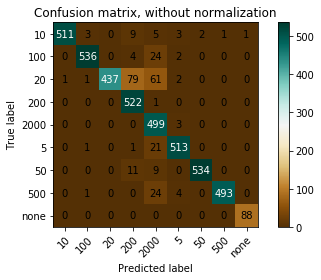

In [0]:
plot_confusion_matrix(train_generator.classes[train_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)

###On Validation

In [0]:
val_generator.shuffle = False

55/55 [==============================] - 23s 419ms/step
Confusion matrix, without normalization
[[116   1   1   2   4   0   0   0   0]
 [  0  69   0   0   3   0   0   0   0]
 [  0   0  52  12   4   0   0   0   0]
 [  0   0   0  75   0   0   0   0   0]
 [  0   0   0   0 107   0   0   0   0]
 [  0   0   0   0   6 118   0   0   0]
 [  0   0   0   0   1   0  98   0   0]
 [  1   0   0   1   5   2   0 169   1]
 [  0   0   0   0   0   1   0   0  22]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       124
           1       0.99      0.96      0.97        72
           2       0.98      0.76      0.86        68
           3       0.83      1.00      0.91        75
           4       0.82      1.00      0.90       107
           5       0.98      0.95      0.96       124
           6       1.00      0.99      0.99        99
           7       1.00      0.94      0.97       179
           8       0.96      0.96      0.96        23

    accura

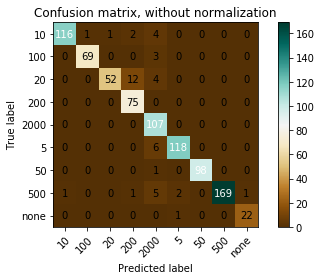

In [0]:
Y_pred = model.predict_generator(val_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(val_generator.classes[val_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)
print(classification_report(val_generator.classes[val_generator.index_array], y_pred))

###On Test

In [0]:
test_generator.shuffle = False

19/19 [==============================] - 8s 416ms/step
Confusion matrix, without normalization
[[ 6  1 15  7 25  3  0  0  0]
 [11  0  0  1 22 27  0  1  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 1  1  0  7  3  1 30  0  0]
 [ 0  0  0  0  0  0  0  0  5]
 [ 0 22  0  0  2  0  0  0  0]
 [ 0  1  0  0 41  0  0  0  0]
 [ 0  0  0  0  2  1  1 18  0]
 [ 9  1  2  6  3  3  5  0  0]]
              precision    recall  f1-score   support

           0       0.22      0.11      0.14        57
           1       0.00      0.00      0.00        62
           2       0.00      0.00      0.00        10
           3       0.23      0.16      0.19        43
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        42
           7       0.95      0.82      0.88        22
           8       0.00      0.00      0.00        29

    accuracy                           0.11       294
   macro avg       0.16      0.12     

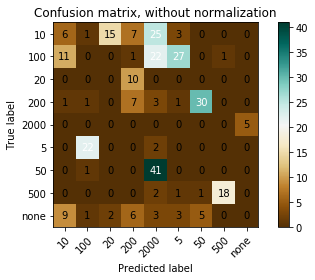

In [0]:
Y_pred = model.predict_generator(test_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000','5', '50', '500', 'none']), False)
print(classification_report(test_generator.classes[test_generator.index_array], y_pred))

## Convert to TFLite

In [0]:
saved_model_dir = path_train_cropped + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-6-448-ResNet.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train-cropped/save/fine_tuning/assets


In [0]:
saved_model_dir

'/content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train-cropped/save/fine_tuning'

Download the converted model and labels

In [0]:
from google.colab import files

files.download(saved_model_dir + '/model-6-448-ResNet.tflite')
# files.download('labels.txt')

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()